In [1]:
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import community
import networkx as nx
import cpnet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import requests
warnings.filterwarnings('ignore')

## Settings

LQTY:

- genesis date:  2021-04-05

LUSD:

- genesis date:  2021-04-15

In [2]:
token_name = 'LQTY'

data_date = datetime.strptime('2022-07-12', '%Y-%m-%d')
data_date_str = data_date.strftime('%y-%m-%d')

start_date = datetime.strptime('2021-04-05', '%Y-%m-%d')
start_date_str = start_date.strftime('%y-%m-%d')

end_date = datetime.strptime('2022-07-11', '%Y-%m-%d')
end_date_str = end_date.strftime('%y-%m-%d')

DATA_DIR = f'../Data/{token_name}_{data_date_str}'
FIGURE_DIR = f'../Figure/{token_name}_{start_date_str}_{end_date_str}'

if os.path.exists(FIGURE_DIR) is False:
    os.makedirs(FIGURE_DIR)

In [15]:
# Read data
def filter_date(df, start_date=start_date, end_date=end_date):
    return df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

# Raw transaction date
dtypes = {'token_address':str, 'from_address':str, 'to_address':str, 'timestamp':str, 'value':np.float64}
raw_tx = pd.read_csv(f'../Data/{token_name}_{data_date_str}.csv', dtype=dtypes)
raw_tx['timestamp'] = pd.to_datetime(raw_tx['timestamp'])
raw_tx = filter_date(raw_tx)

# Aggregated transaction date
dtypes = {'timestamp':str, 'from_address':str, 'to_address':str, 'value':np.float64}
agg_tx = pd.read_csv(f'{DATA_DIR}/01_agg_tx.csv', dtype=dtypes)
agg_tx['timestamp'] = pd.to_datetime(agg_tx['timestamp'])
agg_tx = filter_date(agg_tx)

# Network features
network_fea = pd.read_csv(f'{DATA_DIR}/02_network_fea.csv')
network_fea['timestamp'] = pd.to_datetime(network_fea['timestamp'])
network_fea = filter_date(network_fea)

# Addresses that have been the core nodes
core_address = pd.read_csv(f'{DATA_DIR}/03_core_address.csv')

## Visualization

#### Basic

In [16]:
# Preprocess data
def count_unique_addresses(x):
    addresses = list(x['from_address']) + list(x['to_address'])
    return pd.DataFrame({'address_count': [len(set(addresses))]})

network_fea['address_count'] = raw_tx.groupby('timestamp').apply(count_unique_addresses).reset_index().drop(columns=['level_1'])['address_count']

def sum_value(x):
    return pd.DataFrame({'value_sum': [sum(x['value'])]})

network_fea['value_sum'] = agg_tx.groupby('timestamp').apply(sum_value).reset_index().drop(columns=['level_1'])['value_sum']

network_fea.head()

,timestamp,num_edges,num_nodes,degree_mean,degree_std,top10_degree_mean,top10_degree_std,top10_degree_ratio,degree_centrality_mean,degree_centrality_std,...,eigenvector_centrality_atd,closeness_centrality_mean,closeness_centrality_std,num_components,giant_com_ratio,num_core,avg_core_neighbor,significance,address_count,value_sum
0,2021-04-05,1040,726,2.721763,22.649375,99.1,166.702999,36.410223,0.003754,0.031241,...,0.026966,0.389642,0.059947,1,1.000000,1,548.00,0.0,726,1.000771e+26
1,2021-04-06,1481,861,3.184669,25.139971,136.5,190.741841,42.861597,0.003703,0.029233,...,0.024776,0.379748,0.055193,1,1.000000,2,475.50,0.0,861,2.011123e+23
2,2021-04-07,1101,627,3.336523,21.835254,105.0,139.134467,31.469885,0.005330,0.034881,...,0.028648,0.378865,0.057995,2,0.996810,4,256.25,0.0,627,2.111106e+23
3,2021-04-08,854,505,3.211881,18.794898,81.7,107.395577,25.436806,0.006373,0.037291,...,0.031536,0.372478,0.053112,1,1.000000,4,198.25,0.0,505,2.082648e+23
4,2021-04-09,773,457,3.155361,16.431675,70.5,87.662135,22.342926,0.006920,0.036034,...,0.033388,0.347403,0.058551,2,0.995624,4,165.75,0.0,457,2.565555e+23


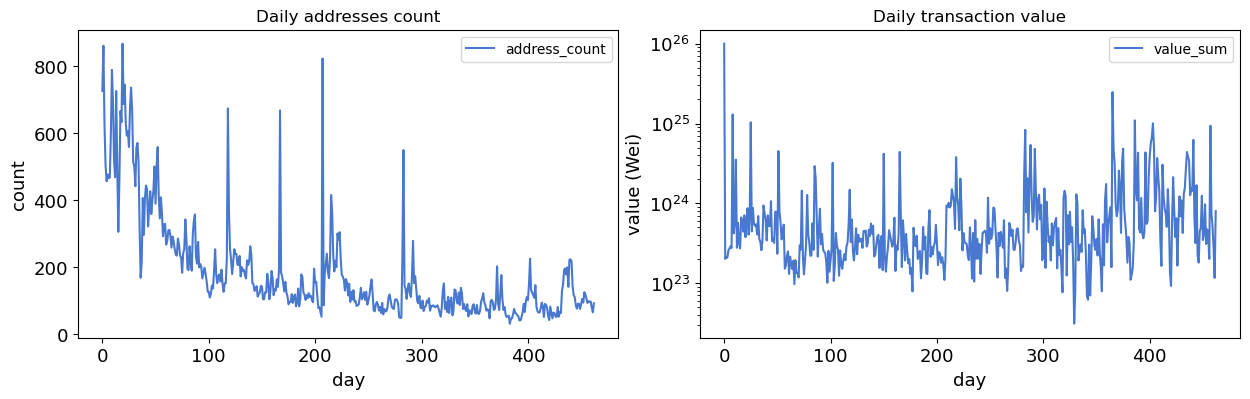

In [17]:
fig,axes = plt.subplots(1,2)
plt.style.use('default')

# Addresses count
network_fea[['address_count']].plot(ax=axes[0], figsize=(15,4), grid=False, title='Daily addresses count', xlabel='day', ylabel='count')

# Tx daily value
ax = network_fea[['value_sum']].plot(ax=axes[1], figsize=(15,4), grid=False, title='Daily transaction value', xlabel='day', ylabel='value (Wei)')
ax.set_yscale('log')

plt.subplots_adjust(wspace =0.15, hspace =0.35)
plt.savefig(f'{FIGURE_DIR}/basic_features.png', dpi=300)

#### Distribution on significant & insignificant days 

Significant days VS Insignificant days: 349 (75.38%) | 114 (24.62%)


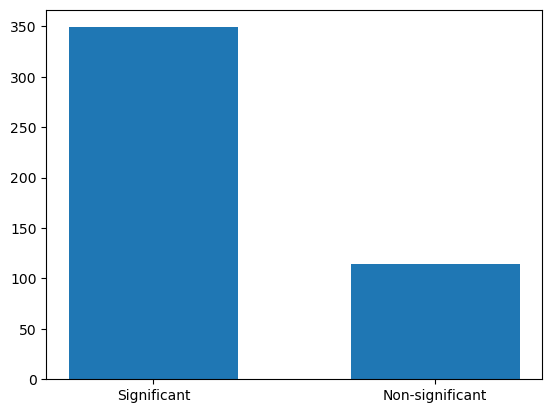

In [18]:
sig_T = network_fea[network_fea['significance'] < 0.05]
sig_F = network_fea[network_fea['significance'] >= 0.05]

plt.bar(['Significant', 'Non-significant'], [len(sig_T), len(sig_F)], width = 0.6)

print('Significant days VS Insignificant days: {} ({:.4}%) | {} ({:.4}%)'.format(len(sig_T), 100*len(sig_T)/len(network_fea), sig_F.shape[0], 100*sig_F.shape[0]/network_fea.shape[0]))

In [19]:
# Visualize
def cp_net_vis(date):
    sample_sig_T_df = agg_tx[agg_tx['timestamp'] == date]

    G = nx.from_pandas_edgelist(sample_sig_T_df, 'from_address', 'to_address', 'value', nx.Graph())
    # Detecting discrete core-periphery structure
    alg = cpnet.BE()        # Load the Borgatti-Everett algorithm
    alg.detect(G)           # Feed the G as an input
    x = alg.get_coreness()  # Get the coreness of nodes
    c = alg.get_pair_id()   # Get the group membership of nodes

    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax, pos = cpnet.draw(G, c, x, ax)


# cp_net_vis(sig_T['timestamp'][10])
# cp_net_vis(sig_F['timestamp'][10])

#### Distribution of core nodes numbers

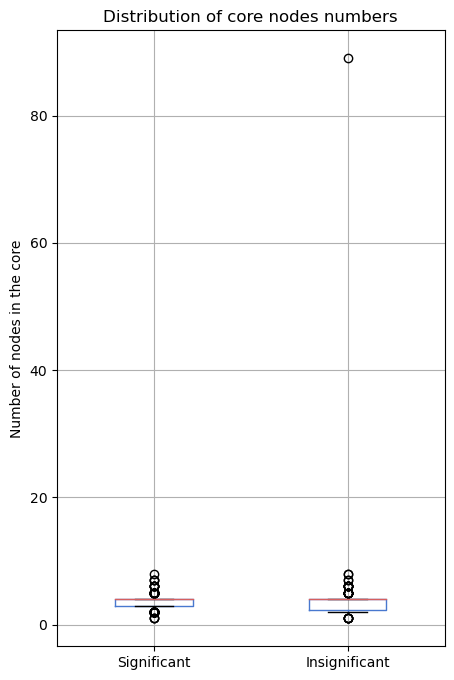

In [20]:
num_core_sig_T = sig_T['num_core']
num_core_sig_F = sig_F['num_core']

plt.style.use('seaborn-muted')
plt.figure(figsize=(5, 8))
dt = pd.DataFrame({'Significant':num_core_sig_T, 'Insignificant':num_core_sig_F})
dt.boxplot(widths = 0.4,whis=0.5)
plt.title('Distribution of core nodes numbers')
plt.ylabel('Number of nodes in the core')
plt.rc('font', size=13) # controls default text sizes
plt.savefig(f'{FIGURE_DIR}/distribution_of_core_nodes_numbers')

In [21]:
sig_F.sort_values(by='num_core')[['timestamp', 'num_core']]

,timestamp,num_core
381,2022-04-21,1
351,2022-03-22,1
421,2022-05-31,1
422,2022-06-01,1
323,2022-02-22,1
...,...,...
303,2022-02-02,7
299,2022-01-29,7
370,2022-04-10,8
366,2022-04-06,8


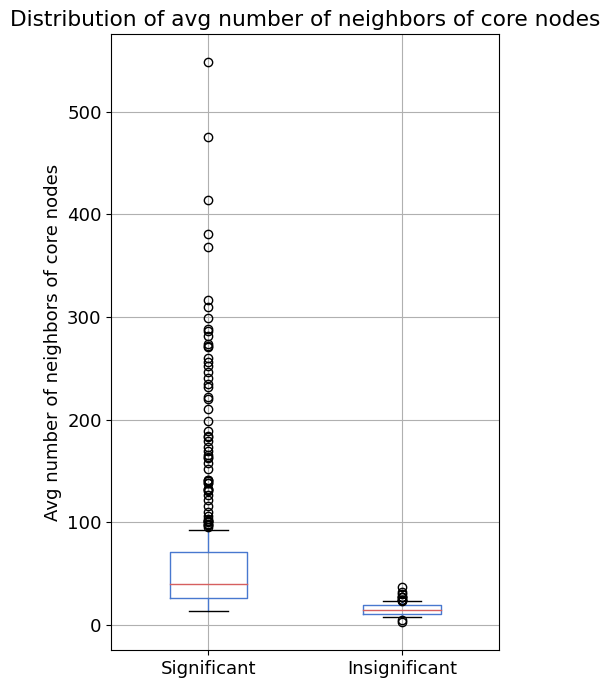

In [22]:
avg_core_neighbor_sig_T = sig_T['avg_core_neighbor']
avg_core_neighbor_sig_F = sig_F['avg_core_neighbor']

plt.figure(figsize=(5, 8))
dt = pd.DataFrame({'Significant':avg_core_neighbor_sig_T, 'Insignificant':avg_core_neighbor_sig_F})
dt.boxplot(widths = 0.4,whis=0.5)
plt.title('Distribution of avg number of neighbors of core nodes')
plt.ylabel('Avg number of neighbors of core nodes')
plt.rc('font', size=13)
plt.savefig(f'{FIGURE_DIR}/distribution_of_avg_number_of_neighbors_of_core_nodes')

#### Core days count distribution of CA and EOA

In [23]:
core_address['type'] = core_address.apply()

,address,core_days_cnt
0,0xd1d5a4c0ea98971894772dcd6d2f1dc71083c44e,426
1,0xd8c9d9071123a059c6e0a945cf0e0c82b508d816,422
2,0x4f9fbb3f1e99b56e0fe2892e623ed36a76fc605d,373
3,0xb13201b48b1e61593df055576964d0b3aab66ea3,142
4,0x28b67e0a4e570720c111c090c45daa065a54e58d,59
...,...,...
110,0xa29744b745800ccd814e6f59271ecd74682eccb0,1
111,0x77cea7e3b23ad8adff53494d39f2be540fc81895,1
112,0x1ffeb270de26348f0c6e9f442bcd89ccaf1449cb,1
113,0x3cc936b795a188f0e246cbb2d74c5bd190aecf18,1


In [ ]:
from etherscan import Etherscan

ApiKey = 'EYNUP3BRHZHGB8RSZWSPXMMGDMZ5Q6PSJE'
eth = Etherscan(ApiKey)

def check_contract(address):
    try:
        eth.get_contract_abi('0x57622d4c4be22ab9ad3Da104dc281d738e6F5b6a')
        return 0
    except:
        return 1

core_address['type'] = core_address['address'].apply(check_contract)


In [10]:
print(f'CA vs EOA: {core_days_cnt_CA.shape[0]} | {core_days_cnt_EOA.shape[0]}')

NameError: name 'core_days_cnt_CA' is not defined

In [11]:
plt.style.use('seaborn-muted')
plt.figure(figsize=(8, 8))
dt = pd.DataFrame({'CA':core_days_cnt_CA['core_days_cnt'], 'EOA':core_days_cnt_EOA['core_days_cnt']})
dt.boxplot(widths = 0.4,whis=0.5)
plt.title('Core days count distribution of CA and EOA')
plt.ylabel('Number of days becoming core')
plt.rc('font', size=15)
plt.savefig(f'{FIGURE_DIR}/Core_days_count_distribution_of_CA_and_EOA')

NameError: name 'core_days_cnt_CA' is not defined

<Figure size 576x576 with 0 Axes>

#### Network Dynamics

In [15]:
network_fea.rename(columns={'significance': 'cp_pvalue'}, inplace=True)

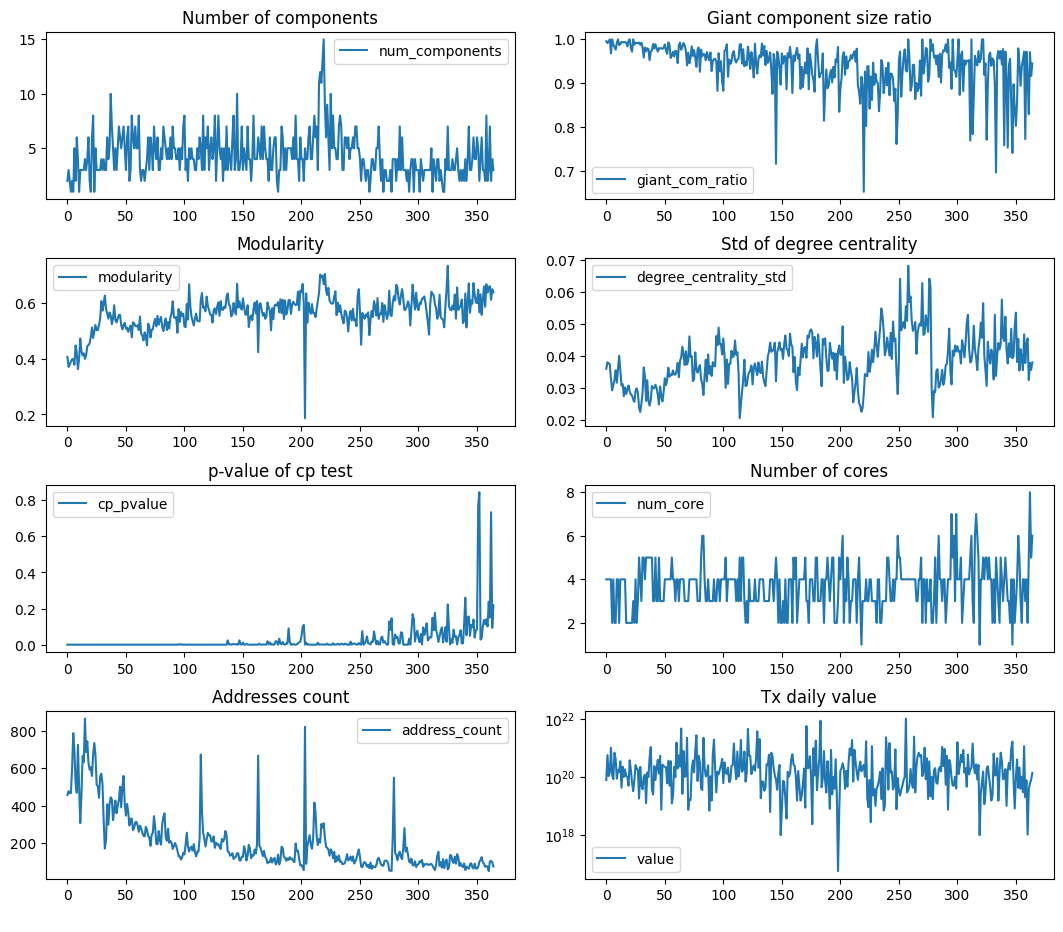

In [17]:
fig,axes = plt.subplots(4,2)
plt.style.use('default')

# Number of components
ax = network_fea[['num_components']].plot(ax=axes[0,0], figsize=(13,10), grid=False, title='Number of components', xlabel=' ')
# ax.set_yscale('log')

# Gaint component ratio
network_fea[['giant_com_ratio']].plot(ax=axes[0,1], figsize=(13,7), grid=False, title='Giant component size ratio', xlabel=' ')

# Modularity
network_fea[['modularity']].plot(ax=axes[1,0], figsize=(13,7), grid=False, title='Modularity', xlabel=' ')

# Std of degree centrality
network_fea[['degree_centrality_std']].plot(ax=axes[1,1], figsize=(13,7), grid=False, title='Std of degree centrality',xlabel=' ')

# p-value of cp test
network_fea[['cp_pvalue']].plot(ax=axes[2,0], figsize=(13,11), grid=False, title='p-value of cp test', xlabel=' ')

# Number of cores
network_fea[['num_core']].plot(ax=axes[2,1], figsize=(13,11), grid=False, title='Number of cores', xlabel=' ')

# Addresses count
network_fea[['address_count']].plot(ax=axes[3,0], figsize=(13,11), grid=False, title='Addresses count', xlabel=' ')

# Tx daily value
ax = network_fea[['value']].plot(ax=axes[3,1], figsize=(13,11), grid=False, title='Tx daily value', xlabel=' ')
ax.set_yscale('log')

plt.subplots_adjust(wspace =0.15, hspace =0.35)
plt.savefig(f'{FIGURE_DIR}/Network_Dynamics')

#### Correlations of network features

In [18]:
network_fea_cor = network_fea[['num_components', 'giant_com_ratio', 'modularity', 'degree_centrality_std', 'significance']].corr()
network_fea_cor

,num_components,giant_com_ratio,modularity,degree_centrality_std,significance
num_components,1.000000,-0.497426,0.219945,-0.375062,-0.145952
giant_com_ratio,-0.497426,1.000000,-0.501614,-0.145061,-0.165643
modularity,0.219945,-0.501614,1.000000,-0.027292,0.249895
degree_centrality_std,-0.375062,-0.145061,-0.027292,1.000000,0.137404
significance,-0.145952,-0.165643,0.249895,0.137404,1.000000


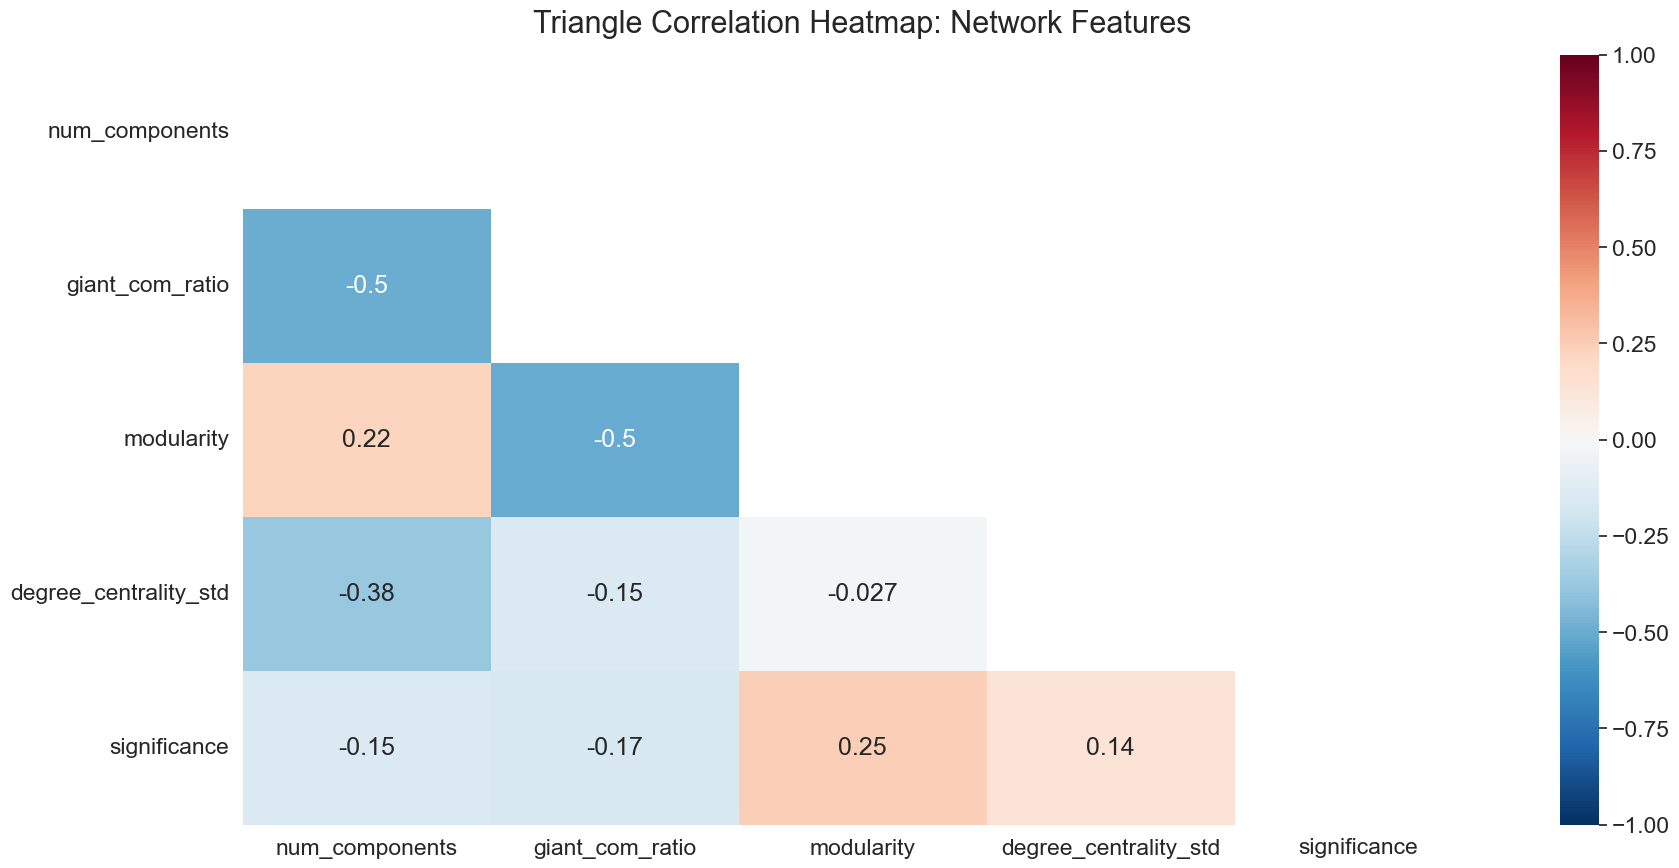

In [29]:
plt.style.use('default')
plt.figure(figsize=(20, 10))

mask = np.triu(np.ones_like(network_fea_cor, dtype=np.bool))
sns.set(font_scale=1.5) 
heatmap = sns.heatmap(network_fea_cor, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r') #control colors: https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/#:~:text=You%20can%20customize%20the%20colors,heatmap()%20function%20in%20seaborn.&text=It%20is%20also%20possible%20to,vmin%20parameters%20in%20the%20function.
heatmap.set_title('Triangle Correlation Heatmap: Network Features', fontdict={'fontsize':22}, pad=16);

heatmap.set_facecolor((1,1,1))
plt.savefig(f'{FIGURE_DIR}/Correlation_Heatmap')
